## **1. GBM**

* 손글씨 숫자 데이터셋을 사용합니다
* 아래 셀을 실행시킨 후 실습을 진행해 주세요

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time, warnings
warnings.filterwarnings('ignore')

digits = load_digits()
X = digits.data
y = digits.target

df_digits = pd.DataFrame(X, columns=[f'pix_{i}' for i in range(X.shape[1])])
df_digits['target'] = y
df_digits.head()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)
print(X_train.shape, X_test.shape)

(1257, 64) (540, 64)


### 1-1. GBM 수행시간 측정


*   GradientBoostingClassifier로 예측 / 분류
*   GBM 정확도 & 학습 시간 출력

*   아래 셀의 빈칸을 채워주세요



In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy ))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9630
GBM 수행 시간: 8.5 초 


### 1-2. 하이퍼 파라미터 튜닝

* 아래 셀의 빈칸을 채워주세요

In [3]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
}
gb_clf = GradientBoostingClassifier(random_state=0)
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=3, n_jobs=-1, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print("GBM 정확도: {0:.4f}".format(gb_accuracy))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
최고 예측 정확도: 0.9578
GBM 정확도: 0.9648


### 1-3. OX 퀴즈

* 괄호 안에 O 또는 X를 표기하고

* X일 경우 아랫줄에 간단한 근거를 적어주세요 (O는 공란으로)

(X) GBM은 트리들을 독립적으로 병렬 학습하므로 대용량에서 매우 빠르다.
- 근거: GBM은 병렬 학습이 제한적이다. (순차학습 수행)

(O) 랜덤 포레스트는 상대적으로 빠른 수행 시간을 보장하는 편이라, 예측 결과 도출이 쉽다.
- 근거:

(O) GBM은 하이퍼파라미터 변화에 민감하여 하이퍼 파라미터 튜닝 노력이 더 필요하다.
- 근거:

(X) 사이킷런 GradientBoostingClassifier는 멀티 CPU 코어를 사용하면 내부적으로 병렬 학습을 수행한다.
- 근거: GradientBoostingClassifier는 병렬 학습을 지원하지 않는다.

## **2. XGBoost**

* 위스콘신 유방암 데이터셋을 사용합니다
* 아래 셀을 실행시킨 후 실습을 진행해 주세요

In [4]:
import xgboost as xgb
from xgboost import plot_importance
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns = dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [5]:
# 타깃 레이블 값 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


### 2-1. 학습/검증/테스트 분할


* 아래 셀의 빈칸을 채워주세요
* random_state=156


In [6]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features=cancer_df.iloc[:,:-1]
y_label=cancer_df.iloc[:,-1]

# 전체 데이터 중 70%는 학습용 데이터, 30%는 테스트용 데이터 추출
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.3,random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 50%는 학습과 50%는 검증용 데이터로 분리
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.5,random_state=156)

print(X_train.shape,X_test.shape)
print(X_tr.shape,X_val.shape)

(398, 30) (171, 30)
(199, 30) (199, 30)


* 아래 셀을 실행시킨 후 실습을 이어서 진행해 주세요



In [7]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안 될 경우 X_train.values로 넘파이 변환
# 학습, 검증, 테스트용 DMatrix 생성
dtr = xgb.DMatrix(data=X_tr.values, label=y_tr.values)
dval = xgb.DMatrix(data=X_val.values, label=y_val.values)
dtest = xgb.DMatrix(data=X_test.values, label=y_test.values)

### 2-2. 하이퍼 파라미터 설정

* 다음 조건에 맞게 하이퍼 파라미터를 설정해 주세요

  * 트리의 최대 깊이: 4

  * 학습률(eta): 0.1

  * 이진 분류

  * 오류 함수의 평가 성능 지표는 logloss

  * 부스팅 반복 횟수: 500회

In [8]:
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}
num_rounds = 500

### 2-3. 조기 종료

* 아래 셀을 실행시킨 후 질문에 답하세요

In [9]:
eval_list = [(dtr, 'train'), (dval, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(
    params=params, dtrain=dtr,
    num_boost_round=num_rounds, evals=eval_list,
    early_stopping_rounds=30
)

[0]	train-auc:0.99730	eval-auc:0.94928
[1]	train-auc:0.99678	eval-auc:0.94792
[2]	train-auc:0.99803	eval-auc:0.95749
[3]	train-auc:0.99948	eval-auc:0.96564
[4]	train-auc:0.99990	eval-auc:0.97233
[5]	train-auc:1.00000	eval-auc:0.97244
[6]	train-auc:0.99979	eval-auc:0.97298
[7]	train-auc:0.99990	eval-auc:0.97037
[8]	train-auc:0.99958	eval-auc:0.97679
[9]	train-auc:0.99948	eval-auc:0.97744
[10]	train-auc:0.99948	eval-auc:0.97847
[11]	train-auc:0.99948	eval-auc:0.97978
[12]	train-auc:0.99958	eval-auc:0.98375
[13]	train-auc:0.99958	eval-auc:0.98424
[14]	train-auc:0.99969	eval-auc:0.98434
[15]	train-auc:0.99979	eval-auc:0.98467
[16]	train-auc:0.99969	eval-auc:0.98511
[17]	train-auc:0.99969	eval-auc:0.98576
[18]	train-auc:0.99979	eval-auc:0.98554
[19]	train-auc:0.99979	eval-auc:0.98532
[20]	train-auc:0.99990	eval-auc:0.98521
[21]	train-auc:1.00000	eval-auc:0.98598
[22]	train-auc:1.00000	eval-auc:0.98565
[23]	train-auc:1.00000	eval-auc:0.98521
[24]	train-auc:1.00000	eval-auc:0.98598
[25]	train

* 조기 종료의 개념을 한 문장으로 설명하고, 위 결과에서 검증 평가 지표의 최적 시점이 num_rounds보다 작게 결정될 수 있는 이유를 간단히 서술하세요

정답: 조기 종료는 모델이 검증 데이터에 대해 더 이상 성능을 개선하지 못하고 과적합되기 시작할 때, 최대 훈련 횟수(num_rounds)를 다 채우기 전에 학습을 중단해 최적의 일반화 성능을 가진 모델을 얻게 해주는 기법이다.

* 남은 코드를 실행하여 결과를 확인해 보세요

In [10]:
dtest = xgb.DMatrix(data=X_test, label=y_test)
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.809 0.005 0.072 0.147 0.955 0.997 0.997 0.993 0.995 0.003]
예측값 10개만 표시: [1, 0, 0, 0, 1, 1, 1, 1, 1, 0]


### 2-4. 시각화
* xgboost 내장 시각화 함수 사용
* 아래 셀의 빈칸을 채워주세요

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

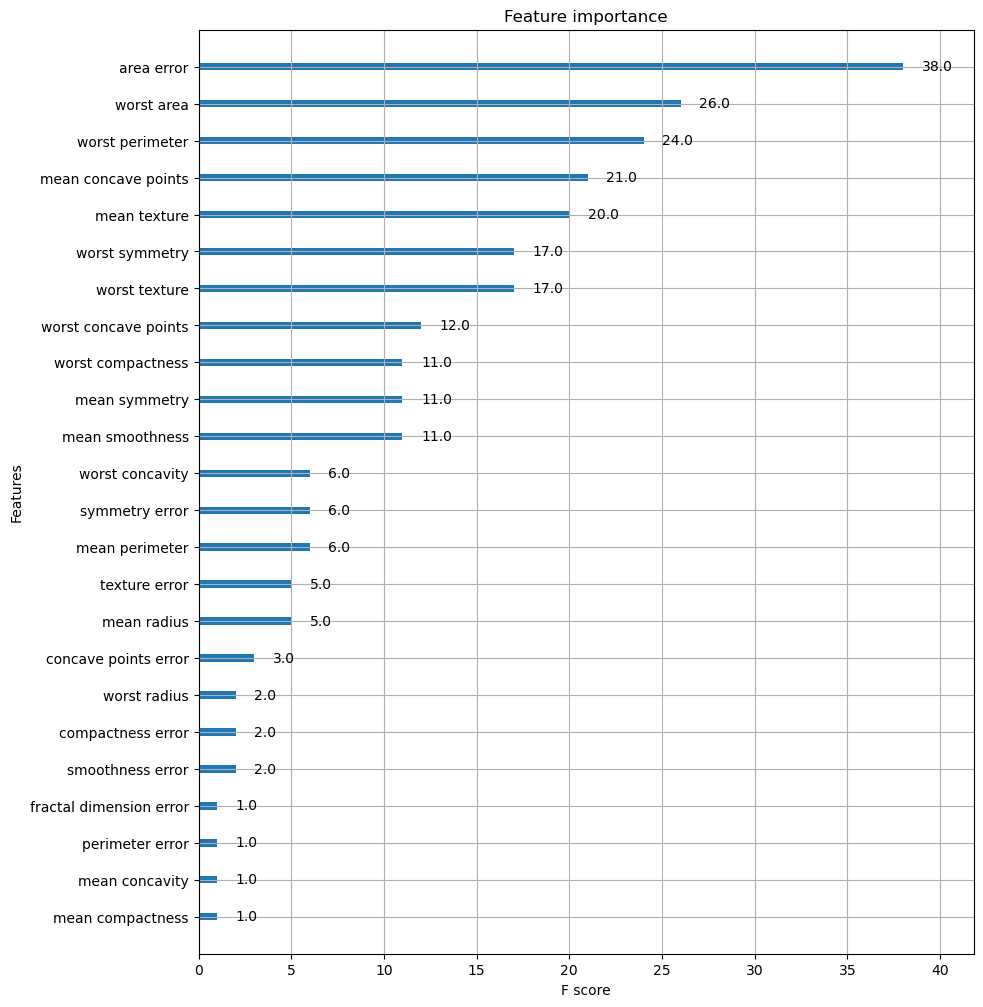

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

## **3. LightGBM**

#### 해당 파트에서는 sklearn 패키지의 wine 데이터 세트를 이용합니다. `# 답안` 위치에 답을 채워넣어 주세요.

In [12]:
# 실습에 필요한 라이브러리이므로 실행해 주세요.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, roc_auc_score, precision_score

from lightgbm import LGBMClassifier, plot_importance

In [13]:
# 실행해 주세요.

# 데이터 로드
dataset = load_wine()

wine_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
wine_df['target'] = dataset.target

# 입력(X), 레이블(y) 분리
X_features = wine_df.iloc[:, :-1]
y_label = wine_df.iloc[:, -1]

### 문제 1. 학습/검증/테스트 데이터 분리하기 
1-1. 전체 데이터 세트의 80%를 학습용으로 분리하세요. <br>
1-2. 학습 데이터의 10%를 검증용으로 다시 분리하세요.

In [14]:
# 전체 데이터 80% 학습, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 학습데이터 다시 90% 학습, 10% 검증
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=156
) 

### 문제 2. LGBM 분류기 생성하기
2-1. wine 데이터 세트 분류를 위해 트리 개수 400, 학습률 0.05로 LightGBM 분류기를 생성하세요. <br>
2-2. X_val, y_val에서 **60번** 동안 성능 개선이 없으면 학습을 멈추도록 설정하세요.

In [15]:
# 2-1.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# 2-2.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(
    X_tr, y_tr,
    early_stopping_rounds=60, # 조기 중단 수행
    eval_metric="multi_logloss",
    eval_set=evals,
    verbose=True
)

[1]	training's multi_logloss: 1.01146	valid_1's multi_logloss: 0.995504
[2]	training's multi_logloss: 0.941053	valid_1's multi_logloss: 0.94871
[3]	training's multi_logloss: 0.877814	valid_1's multi_logloss: 0.908512
[4]	training's multi_logloss: 0.82067	valid_1's multi_logloss: 0.870304
[5]	training's multi_logloss: 0.769274	valid_1's multi_logloss: 0.828551
[6]	training's multi_logloss: 0.721784	valid_1's multi_logloss: 0.796799
[7]	training's multi_logloss: 0.67831	valid_1's multi_logloss: 0.766615
[8]	training's multi_logloss: 0.638756	valid_1's multi_logloss: 0.741104
[9]	training's multi_logloss: 0.602232	valid_1's multi_logloss: 0.711887
[10]	training's multi_logloss: 0.568127	valid_1's multi_logloss: 0.6882
[11]	training's multi_logloss: 0.536855	valid_1's multi_logloss: 0.670315
[12]	training's multi_logloss: 0.507561	valid_1's multi_logloss: 0.648423
[13]	training's multi_logloss: 0.480867	valid_1's multi_logloss: 0.628687
[14]	training's multi_logloss: 0.453999	valid_1's mul

LGBMClassifier(learning_rate=0.05, n_estimators=400)

### 문제 3. 예측하기
3-1. 학습된 LightGBM 분류기를 이용해 테스트 세트에 대한 예측을 수행하세요. <br>
3-2. predict() 메서드를 사용해 클래스 예측값 preds을 구하세요.<br> 

In [16]:
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)


# 출력 확인
print("예측 클래스(앞 10개):", preds[:10])
print("예측 확률 행렬 shape:", pred_proba.shape)
print("예측 확률 (앞 5개 샘플):\n", np.round(pred_proba[:5], 3))

예측 클래스(앞 10개): [1 2 0 1 1 2 1 0 1 1]
예측 확률 행렬 shape: (36, 3)
예측 확률 (앞 5개 샘플):
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


### 문제 4. 피처 중요도 시각화하기 
빈칸을 채워 각 피처의 중요도를 시각화하세요.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

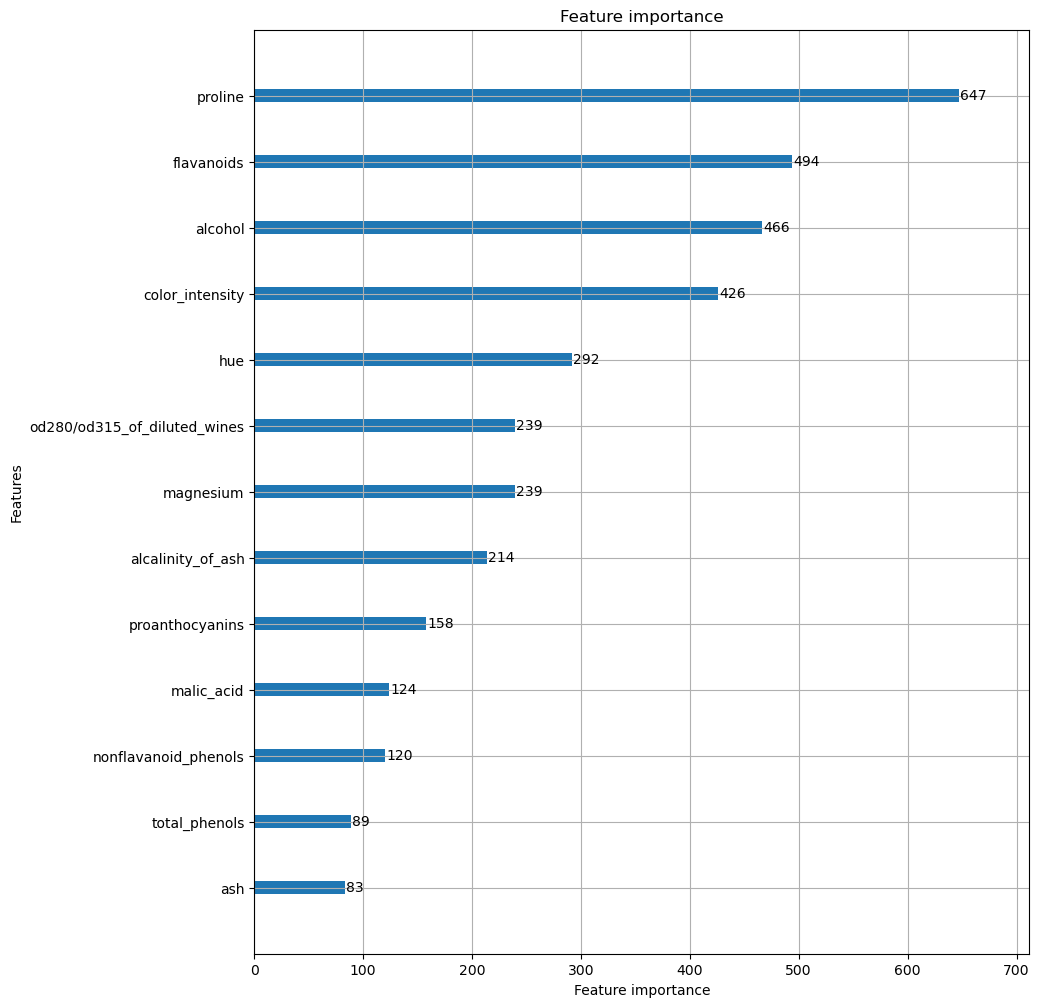

In [17]:
# 피처 중요도 시각화하는 내장 API: plot_importance 
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

## **4. 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝**

#### 해당 파트에서는 diabetes 데이터 세트를 이용합니다. `# 답안` 위치에 답을 채워넣어 주세요.

In [19]:
# 실행해 주세요.

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
np.random.seed(156)

# 데이터 로드: 실습 환경에 맞추어 변경해 주세요. 
diabetes_df = pd.read_csv("diabetes.csv")

X_features = diabetes_df.iloc[:, :-1]  
y_label    = diabetes_df.iloc[:, -1] 

# 전체 데이터 중 80%는 학습용, 20%는 테스트용
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_label, test_size=0.2, stratify=y_label, random_state=156)

# 앞에서 추출한 학습 데이터를 다시 학습/검증 데이터로 분리 (9:1)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=156)

### 문제 1. 검색공간 정의
아래와 같이 max_depth와 min_child_weight, learning_rate, colsample_bytree를 하이퍼 파라미터 검색 공간으로 정의하려고 합니다. 빈칸을 채우세요. <br>
- max_depth는 3~10 범위에서 1 간격
- min_child_weight는 1~6 범위에서 1 간격

In [20]:
from hyperopt import hp
xgb_search_space = {
    'max_depth':        hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'learning_rate':    hp.uniform('learning_rate', 0.01, 0.3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}

hp.quniform(label, low, high, q): 정수형 파라미터에 적용. <br>
- label로 입력된 변수 공간을 low부터 high까지 q 간격으로 설정. <br> 

hp.uniform(label, low, high): low부터 high까지 정규 분포 형태의 탐색 공간 설정. 

### 문제 2. 목적함수 작성
2-1. HyperOpt의 fmin 함수는 trials 객체를 통해 각 반복의 하이퍼 파라미터 값과 손실 함수 결과값을 기록합니다. 이 기록이 저장되는 Trials 객체의 두 가지 주요 속성은 무엇인가요?<br>
2-2. 아래는 목적함수 objective_func를 정의하는 코드입니다. 빈칸을 채우세요. (평가 지표는 정확도입니다.)<br>
2-3. 답안1, 답안2에 왜 그 답을 입력했는지 이유를 서술하세요.<br>
2-4. 답안5에 왜 그 답을 입력했는지 이유를 서술하세요.

#### 2-1. 
results, vals
#### 2-3. 
HyperOpt의 hp.quniform 함수는 반환 값의 타입이 실수(float)입니다. 하지만 XGBoost 모델의 max_depth와 min_child_weight 파라미터는 정수 타입의 값을 필요로 하므로, int()를 사용하여 명시적으로 타입을 변환해 주어야 합니다.  
#### 2-4. 
HyperOpt의 fmin() 함수는 목적 함수의 'loss' 값을 **최소화**하는 방향으로 최적의 하이퍼 파라미터를 찾습니다. 이 문제에서는 평가 지표로 **정확도(accuracy)**를 사용하고 있는데, 정확도는 <u>높을수록 좋은 모델</u>입니다. 따라서 정확도를 최대화하기 위해서는 (정확도 * -1) 값을 최소화하도록 설정해야 합니다. 즉, -1*accuracy를 반환하여 fmin()이 이 값을 최소화하게 만들면, 결과적으로는 acc(정확도)를 최대화하는 파라미터를 찾게 됩니다.

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK

def objective_func(search_space):
    clf = XGBClassifier(
        n_estimators=100,
        max_depth=int(search_space['max_depth']),
        min_child_weight=int(search_space['min_child_weight']),
        learning_rate=search_space['learning_rate'],
        colsample_bytree=search_space['colsample_bytree'],
        eval_metric='logloss',
        random_state=156
    )
    accuracy = cross_val_score(clf, X_tr, y_tr, scoring='accuracy', cv=3).mean()
    return {'loss': -1 * accuracy, 'status': STATUS_OK}

### 문제 3. fmin() 활용해 최적 하이퍼 파라미터 도출하기

In [22]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|████████| 50/50 [00:34<00:00,  1.43trial/s, best loss: -0.7626811594202897]
best: {'colsample_bytree': 0.7287713619230314, 'learning_rate': 0.034543936004700584, 'max_depth': 6.0, 'min_child_weight': 3.0}


In [23]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.72877, learning_rate:0.03454, max_depth:6, min_child_weight:3


## 5. **데이터 가공(로그 변환)**

In [24]:
# 실행해주세요.
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [25]:
# Pima Indians Diabetes Dataset 불러오기.
import pandas as pd
from sklearn.datasets import fetch_openml

diabetes = fetch_openml(name="diabetes", version=1, as_frame=True, parser="auto")

# 'df'에 데이터프레임으로 저장
df = diabetes.frame

# 레이블값 : class. class=0(tested_negative), class=1(tested_positive)
df["class"] = df["class"].map({"tested_negative": 0, "tested_positive": 1})
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 5-1. 왜곡된 분포도를 가진 데이터를 로그변환하여 가공하기

In [26]:
df_copy = df.copy()
# 넘파이의 log1p( )를 이용해 plas를 로그 변환
plas_n = np.log1p(df_copy['plas'])
df_copy.insert(0, 'plas_Scaled', plas_n)
df_copy.drop(['plas'], axis=1, inplace=True)

print(df_copy)

     plas_Scaled  preg  pres  skin  insu  mass   pedi  age class
0       5.003946     6    72    35     0  33.6  0.627   50     1
1       4.454347     1    66    29     0  26.6  0.351   31     0
2       5.214936     8    64     0     0  23.3  0.672   32     1
3       4.499810     1    66    23    94  28.1  0.167   21     0
4       4.927254     0    40    35   168  43.1  2.288   33     1
..           ...   ...   ...   ...   ...   ...    ...  ...   ...
763     4.624973    10    76    48   180  32.9  0.171   63     0
764     4.812184     2    70    27     0  36.8  0.340   27     0
765     4.804021     5    72    23   112  26.2  0.245   30     0
766     4.844187     1    60     0     0  30.1  0.349   47     1
767     4.543295     1    70    31     0  30.4  0.315   23     0

[768 rows x 9 columns]


### 5-2. 데이터 분할

In [27]:
# DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
X_features = df_copy.iloc[:, :-1]
y_target = df_copy.iloc[:, -1]
# train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
X_train, X_test, y_train, y_test = \
train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)  

### 5-3. 데이터 가공 후 로지스틱 회귀 수행

In [28]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=1000) # 로지스틱 회귀 모델 객체 생성. max_iter=1000: 학습시 최대 반복 횟수 1000
lr_clf.fit(X_train, y_train) # 학습용 데이터로 학습. lr_clf안에 학습된 가중치와 절편 저장
lr_pred = lr_clf.predict(X_test) # 학습된 모델로 테스트 데이터의 클래스(label) 예측.
print('예측 정확도:', accuracy_score(y_test, lr_pred))

예측 정확도: 0.7619047619047619


## 6. 이상치 제거

### 6-1. 피처별로 상관도 구한 뒤 시각화

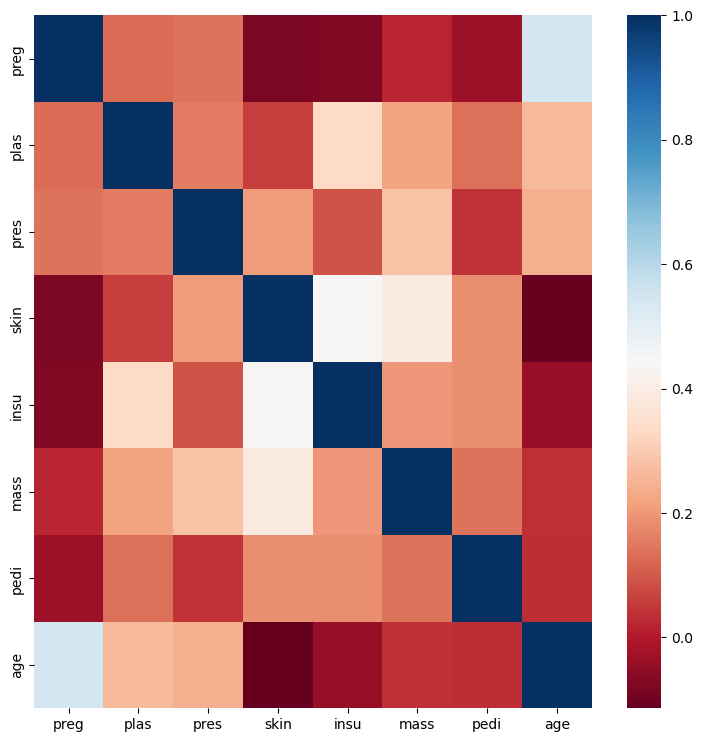

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9, 9))
corr = df.corr() # 각 피처별로 상관도 구하기
sns.heatmap(corr, cmap='RdBu')
plt.show()

### 6-2. 이상치 찾아서 제거하기

In [30]:
# 실행해주세요.
df_copy= df.copy()

In [31]:
# tested_positive, 즉 class=1에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
positive = df[df['class']==1]['pres'] # 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처(색깔이 가장 진한 빨간색)를 선택

Q1 = np.percentile(positive.values, 25) # numpy배열로 변환하고, 25%지점 구함
Q3 = np.percentile(positive.values, 75)

# IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
iqr = Q3 - Q1
iqr_weight = iqr * 1.5
lowest_val = Q1 - iqr_weight # 이상치 경계
highest_val = Q3 + iqr_weight # 이상치 경계

# 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
outlier_index = positive[(positive< lowest_val) | (positive > highest_val)].index

# outlier_index에 해당하는 이상치 데이터 제거
df_copy.drop(outlier_index, axis=0, inplace=True)



### (3) LightGBM모델 수행

In [32]:
X_features = df_copy.iloc[:, :-1]
y_target = df_copy.iloc[:, -1]
# train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
X_train, X_test, y_train, y_test = \
train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

In [33]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, max_depth=-1, n_jobs=-1, boost_from_average=False, random_state=42, verbose=-1)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test) 
print('예측 정확도:', accuracy_score(y_test, lgbm_pred))

예측 정확도: 0.7633928571428571


## 7. 기본 스태킹 모델

### 7-1. 개별 모델 학습/예측

In [34]:
# 학습과 테스트 데이터 분할
df_copy = df.copy()
X_features = df_copy.iloc[:, :-1]
y_target = df_copy.iloc[:, -1]
X_train, X_test, y_train, y_test = \
train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier(random_state=0)
ada_clf = AdaBoostClassifier(n_estimators=100,random_state=0)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression()

# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

### 7-2. 최종 메타 모델 학습/예측

In [35]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(knn_pred.shape, rf_pred.shape, dt_pred.shape, ada_pred.shape, pred.shape)
# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)

# 예측 데이터로 생성된 데이터 세트를 기반으로 최종 메타 모델인 로지스틱 회귀를 학습
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

# 예측 정확도 측정
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

(231,) (231,) (231,) (231,) (4, 231)
최종 메타 모델의 예측 정확도: 0.7619
